In [4]:
import numpy as np


def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1.0 - np.tanh(x)**2


def logistic(x):
    return 1/(1 + np.exp(-x))


def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))


class NeuralNetwork:
    def __init__(self, layers, activation='tanh'):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_derivative

        self.weights = []
        for i in range(1, len(layers)):  # initialize weights
            if i == len(layers)-1:
                self.weights.append((2 * np.random.random((layers[i - 1] + 1, layers[i])) - 1) * 0.25)
            else:
                self.weights.append((2 * np.random.random((layers[i - 1] + 1, layers[i] + 1)) - 1) * 0.25)

    def fit(self, X, y, learning_rate=0.2, epochs=10000):
        """
        Use labeled input data to train the neural network.
        :param X: input data
        :param y: label
        :param learning_rate:
        :param epochs:
        :return:
        """
        X = np.atleast_2d(X)
        temp = np.ones([X.shape[0], X.shape[1]+1])
        temp[:, 0:-1] = X  # adding bias to input layer
        X = temp
        y = np.array(y)

        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):  # forward
                a.append(self.activation(np.dot(a[l], self.weights[l])))

            error = y[i] - a[-1]
            deltas = [error * self.activation_deriv(a[-1])]

            for l in range(len(a) - 2, 0, -1):  # backward
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_deriv(a[l]))
            deltas.reverse()
            for i in range(len(self.weights)):  # update
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)

    def predict(self, x):
        """
        Use trained network to make prediction.
        :param x: input data
        :return: prediction result
        """
        x = np.array(x)
        temp = np.ones(x.shape[0]+1)
        temp[0:-1] = x
        a = temp
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a


In [5]:
import numpy as np
from skimage import io, data, color

import matplotlib.pyplot as plt



def window(pic, i, j):
    """
    Get the surrounding 3x3 pixel window given pixel (i,j).
    :param pic: input picture, should have only one channel
    :param i:
    :param j:
    :return: a list of surrounding pixels
    """
    arr = []
    for p in range(i-1, i+2):
        for q in range(j-1, j+2):
            arr.append(pic[p, q])
    return arr


def color_normalize(pic):
    """
    Pre-process a true color picture, modify its RGB value to be 0, 64, 128, 192.
    :param pic:
    :return: picture after pre-process
    """
    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            pic[i, j, 0] = (pic[i, j, 0] // 64) * 64
            pic[i, j, 1] = (pic[i, j, 1] // 64) * 64
            pic[i, j, 2] = (pic[i, j, 2] // 64) * 64
    return pic


def to_onehot(num):
    """
    Calculate the one-hot code of decimal number 0-3.
    0: [1, 0, 0, 0]
    1: [0, 1, 0, 0]
    2: [0, 0, 1, 0]
    3: [0, 0, 0, 1]
    :param num: any decimal number between 0 to 3
    :return: its one-hot code
    """
    onehot = []
    for i in range(4):
        if i == num:
            onehot.append(1)
        else:
            onehot.append(0)
    return onehot


def onehot_recover(onehot):
    """
    Change one-hot code back to decimal format.
    :param onehot: one-hot code
    :return: corresponding decimal number
    """
    num = 0
    for i in range(4):
        if round(onehot[i]) == 1:
            num = i
    return num


def evaluate(original, prediction):
    """
    Calculate the average difference between the predicted img and the original img.
    Difference of two pixel is calculated by |(R1-R2) + (G1-G2) + (B1-B2)|/64
    :param original:
    :param prediction:
    :return:
    """
    result = (original - prediction) / 64
    count = np.sum(np.abs(result))
    return count / (result.shape[0] * result.shape[1])



In [6]:
layers = [9, 9, 4]
learning_rate = 0.1
epochs = 20000

# Pull image data from library or file
img_original = data.coffee()

In [9]:
img_original.shape

(400, 600, 3)

In [14]:
display(img_original[0])

array([[ 21,  13,   8],
       [ 21,  13,   9],
       [ 20,  11,   8],
       ...,
       [228, 182, 138],
       [231, 185, 142],
       [228, 184, 140]], dtype=uint8)

In [15]:
img = color_normalize(img_original)

In [16]:
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [192, 128, 128],
        [192, 128, 128],
        [192, 128, 128]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [192, 128, 128],
        [192, 128, 128],
        [192, 128, 128]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [192, 128, 128],
        [192, 128, 128],
        [192, 128, 128]],

       ...,

       [[128,  64,  64],
        [192, 128,  64],
        [192, 128,  64],
        ...,
        [128,  64,   0],
        [128,  64,   0],
        [128,  64,   0]],

       [[192, 128,  64],
        [192, 128,  64],
        [192, 128,  64],
        ...,
        [128,  64,   0],
        [128,  64,   0],
        [128,  64,   0]],

       [[192, 128,  64],
        [192, 128,  64],
        [192, 128,  64],
        ...,
        [128,  64,   0],
        [128,  64,   0],
        [128,   0,   0]]

In [17]:
from PIL import Image

In [18]:
img = Image.fromarray(img, 'RGB')

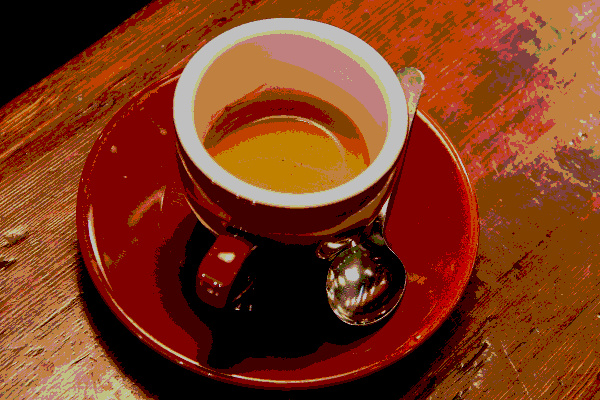

In [19]:
display(img)

In [21]:
result = np.zeros([400, 300, 3], dtype=np.uint8)

In [22]:
result.shape

(400, 300, 3)

In [ ]:
data 